# Training and Prediction : 3D U-Net Model

In [2]:
import os
import numpy as np
from custom_datagen import imageLoader
import keras
from matplotlib import pyplot as plt
import glob
import random

In [3]:
train_img_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/train/masks/"

In [4]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [5]:
num_images = len(os.listdir(train_img_dir))

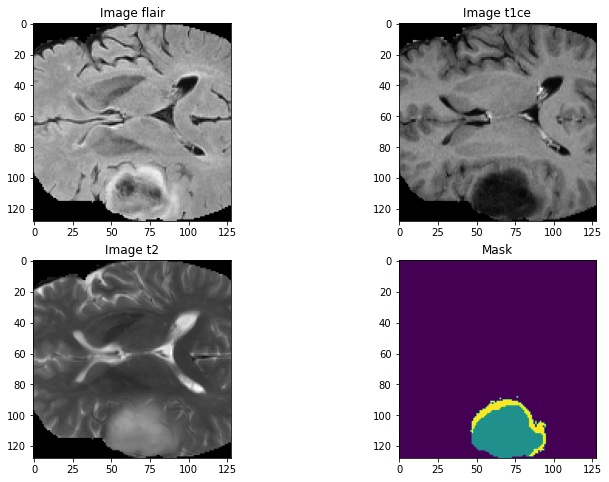

In [6]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [7]:
#Define the image generators for training and validation

train_img_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "D:/BraTS2020 Dataset/BraTS2020 Dataset/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [8]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [9]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

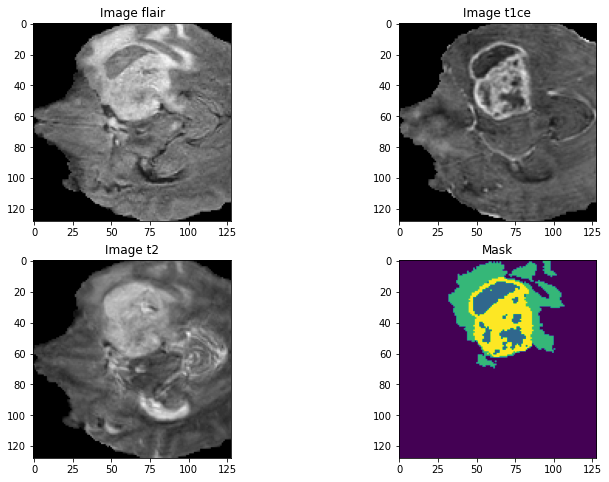

In [11]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [12]:
!pip install segmentation-models-3D

In [13]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  simple_3d_unet_model import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=100, verbose=1, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

model.save('brats_3d.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

                                64)                                                               
                                                                                                  
 max_pooling3d_6 (MaxPooling3D)  (None, 16, 16, 16,   0          ['conv3d_24[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_25 (Conv3D)             (None, 16, 16, 16,   221312      ['max_pooling3d_6[0][0]']        
                                128)                                                              
                                                                                                  
 dropout_12 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_25[0][0]']              
                                128)                                                              
          

 conv3d_36 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_17[0][0]']             
                                8, 16)                                                            
                                                                                                  
 conv3d_37 (Conv3D)             (None, 128, 128, 12  68          ['conv3d_36[0][0]']              
                                8, 4)                                                             
                                                                                                  
Total params: 5,645,828
Trainable params: 5,645,828
Non-trainable params: 0
__________________________________________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputL

                                                                                                  
 conv3d_30 (Conv3D)             (None, 16, 16, 16,   442496      ['dropout_14[0][0]']             
                                128)                                                              
                                                                                                  
 conv3d_transpose_5 (Conv3DTran  (None, 32, 32, 32,   65600      ['conv3d_30[0][0]']              
 spose)                         64)                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 32, 32,   0           ['conv3d_transpose_5[0][0]',     
                                128)                              'conv3d_24[0][0]']              
                                                                                                  
 conv3d_31